# LLM Text Preprocessing Foundations

This notebook explores the fundamental concepts from Chapter 2 of *Build a Large Language Model (From Scratch)* by Sebastian Raschka.

### Learning Objectives:
- Understand tokenization strategies (word-level, character-level, subword)
- Implement Byte Pair Encoding (BPE) tokenization
- Create training samples using sliding windows
- Generate token embeddings
- Experiment with hyperparameters and understand their impact

In [ ]:
# !pip install torch tiktoken numpy matplotlib

In [2]:
import re
import torch
import tiktoken
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.10.0
tiktoken version: 0.12.0


## 1. Loading and Preparing Text Data

The quality and preprocessing of training data directly impacts model performance. For LLMs and agentic systems:

- **Data is the foundation**: Models learn patterns, syntax, semantics, and even reasoning from raw text
- **Preprocessing choices matter**: How we clean and structure text affects what the model learns
- **Scale requirements**: LLMs need massive text corpora (billions of tokens) to learn language effectively
- **Agentic implications**: For AI agents to interact naturally, they must be trained on diverse, high-quality conversational and instructional text


In [3]:
import urllib.request

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
file_path = "the-verdict.txt"

urllib.request.urlretrieve(url, file_path)

with open(file_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

print(f"Total characters: {len(raw_text)}")
print(f"First 500 characters:\n{raw_text[:500]}")

Total characters: 20479
First 500 characters:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


## 2. Tokenization

Tokenization is the critical bridge between human language and machine learning

- **Vocabulary size tradeoff**: 
  - Word-level: Large vocabularies (100K+ words), but handles known words well
  - Character-level: Tiny vocabulary (~100), but sequences become very long

- **Why BPE wins for LLMs**:
  - Efficiently handles rare words by breaking them into common subwords
  - No "unknown token" problem for new words
  - Balances sequence length with vocabulary size

- **Impact on agentic systems**:
  - Better tokenization = better understanding of domain-specific terms, code, URLs, etc.
  - Agents need to handle diverse inputs (technical terms, names, multilingual text)
  - Token efficiency directly affects inference cost and latency

In [4]:
# Simple word-level tokenization (baseline)
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(f"Total tokens (simple): {len(preprocessed)}")
print(f"First 30 tokens: {preprocessed[:30]}")

Total tokens (simple): 4649
First 30 tokens: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [5]:
# Build vocabulary
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(f"Vocabulary size: {vocab_size}")

vocab = {token: integer for integer, token in enumerate(all_words)}
print(f"First 20 vocabulary entries: {list(vocab.items())[:20]}")

Vocabulary size: 1159
First 20 vocabulary entries: [('!', 0), ('"', 1), ("'", 2), ('(', 3), (')', 4), (',', 5), ('--', 6), ('.', 7), (':', 8), (';', 9), ('?', 10), ('A', 11), ('Ah', 12), ('Among', 13), ('And', 14), ('Are', 15), ('Arrt', 16), ('As', 17), ('At', 18), ('Be', 19)]


In [6]:
# Simple tokenizer class
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i: s for s, i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(f"Encoded: {ids}")
print(f"Decoded: {tokenizer.decode(ids)}")

Encoded: [1, 58, 2, 872, 1013, 615, 541, 763, 5, 1155, 608, 5, 1, 69, 7, 39, 873, 1136, 773, 812, 7]
Decoded: " It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


### BPE Tokenization

In [7]:
# Use GPT-2's BPE tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(f"Encoded text: {integers}")
print(f"Decoded text: {tokenizer.decode(integers)}")
print(f"\nGPT-2 vocabulary size: {tokenizer.n_vocab}")

Encoded text: [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
Decoded text: Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.

GPT-2 vocabulary size: 50257


In [8]:
# Tokenize the full text
enc_text = tokenizer.encode(raw_text)
print(f"Total tokens in text: {len(enc_text)}")
print(f"First 50 token IDs: {enc_text[:50]}")

Total tokens in text: 5145
First 50 token IDs: [40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11]


## 3. Training with Sliding Windows

LLMs learn to predict the next token given a context window. The sliding window approach is crucial:

- **Context learning**: Each sample teaches the model to predict token N+1 given tokens 1 to N
- **Efficient training**: By using overlapping windows (stride < max_length), we create more training examples from limited data
- **Position awareness**: Models learn that tokens at different positions have different roles
- **Sequence modeling**: This structure teaches causality—the model learns that earlier tokens influence later ones

**For agentic systems**: 
- Sliding windows help models learn multi-turn conversations
- Overlapping contexts improve understanding of long-range dependencies
- This is why agents can maintain coherent conversations—they learn from overlapping context windows during training

### The `max_length` and `stride` Parameters:
- **max_length**: The context window size (how many tokens the model sees)
- **stride**: How many tokens to shift the window (smaller stride = more overlap = more training samples)

In [9]:
# Data loader for creating input-target pairs
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last
    )
    return dataloader

class GPTDatasetV1(torch.utils.data.Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt)
        
        # Create sliding windows
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [10]:
# Create a dataloader with default parameters
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=8,
    max_length=4,
    stride=4,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")
print(f"\nInput batch:\n{inputs}")
print(f"\nTarget batch:\n{targets}")

Input shape: torch.Size([8, 4])
Target shape: torch.Size([8, 4])

Input batch:
tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Target batch:
tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 4. Token Embeddings

Embeddings turn words (tokens) into numbers the model can work with.  
Instead of `"cat" = ID 2435`, it becomes a vector like `[0.23, -0.45, 0.12, ...]`.  
That vector is learned, not hand-coded.

### Why do embeddings capture meaning?

- **Similar words end up close together**  
  Words used in similar contexts get similar vectors  
  (`cat ≈ dog`, measured with cosine similarity)

- **They’re learned during training**  
  The model starts with random vectors  
  Backpropagation nudges them so words that appear together move closer  
  Over time, meaning emerges from usage

- **Meaning becomes geometry**  
  Position = meaning  
  Relationships become directions  
  (`king - man + woman ≈ queen`)

### How embeddings fit into neural networks

- **They’re just a learnable matrix**  
  Token ID → row lookup → dense vector  
  Simple, but powerful

- **They’re the first layer**  
  Everything else (attention, MLPs) builds on embeddings  
  Bad embeddings = weak understanding

- **They’re shared everywhere**  
  The word `"cat"` uses the same base embedding no matter where it appears  
  Classic parameter sharing

- **Size matters**  
  Small vectors: faster, less expressive  
  Large vectors: richer meaning, more compute  
  (bias–variance tradeoff)

### Why this matters for agents

- Understands synonyms (`buy ≈ purchase`)
- Transfers knowledge to new tasks
- Context refines meaning (`bank` ≠ `river bank`)

**Bottom line:**  
Embeddings turn language into a continuous space where learning works.  
LLMs don’t “understand” words directly — they understand *where words live* relative to each other.


In [11]:
# Create token embeddings
vocab_size = 50257  # GPT-2's vocabulary size
output_dim = 256    # Embedding dimension

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

print(f"Embedding layer shape: {embedding_layer.weight.shape}")
print(f"This is a matrix with {vocab_size:,} rows (one per token) and {output_dim} columns (embedding dimensions)")

Embedding layer shape: torch.Size([50257, 256])
This is a matrix with 50,257 rows (one per token) and 256 columns (embedding dimensions)


In [12]:
# Example: embed some token IDs
sample_ids = torch.tensor([2, 5, 1000, 8000])
embedded = embedding_layer(sample_ids)

print(f"Input token IDs: {sample_ids}")
print(f"Embedded vectors shape: {embedded.shape}")
print(f"\nFirst embedded vector (token ID 2):\n{embedded[0][:20]}...")  # Show first 20 dims

Input token IDs: tensor([   2,    5, 1000, 8000])
Embedded vectors shape: torch.Size([4, 256])

First embedded vector (token ID 2):
tensor([-1.3152, -0.0677, -0.1350, -0.5183,  0.2326,  1.6311, -0.8707,  0.0490,
        -0.2526,  0.0810,  1.2702,  0.7397,  1.0890, -0.6591, -0.1910,  0.5061,
         1.7788, -0.7092, -1.5262, -1.4693], grad_fn=<SliceBackward0>)...


In [13]:
# Embed a batch from our dataloader
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

token_embeddings = embedding_layer(inputs)
print(f"Input batch shape: {inputs.shape}")
print(f"Token embeddings shape: {token_embeddings.shape}")
print(f"Each batch item now has {token_embeddings.shape[1]} tokens, each represented by a {token_embeddings.shape[2]}-dimensional vector")

Input batch shape: torch.Size([8, 4])
Token embeddings shape: torch.Size([8, 4, 256])
Each batch item now has 4 tokens, each represented by a 256-dimensional vector


### Adding Positional Embeddings

In [14]:
# Positional embeddings
context_length = 4  # Same as max_length in our dataloader
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(f"Positional embeddings shape: {pos_embeddings.shape}")
print(f"Each position (0 to {context_length-1}) has its own {output_dim}-dimensional vector")

Positional embeddings shape: torch.Size([4, 256])
Each position (0 to 3) has its own 256-dimensional vector


In [15]:
# Combine token and positional embeddings
input_embeddings = token_embeddings + pos_embeddings
print(f"Final input embeddings shape: {input_embeddings.shape}")
print(f"\nThese combined embeddings are what feed into the transformer blocks!")
print(f"Each token now has both semantic (what it means) and positional (where it is) information.")

Final input embeddings shape: torch.Size([8, 4, 256])

These combined embeddings are what feed into the transformer blocks!
Each token now has both semantic (what it means) and positional (where it is) information.


## 5. Experiment: Impact of max_length and stride

Experiment with different `max_length` and `stride` values to understand their impact on dataset creation.

**Hypothesis**: 
- Smaller stride → More overlap → More training samples
- Larger max_length → Longer context → Fewer samples (if text length is fixed)

**Why overlap**:
- Provides more training examples from limited data
- Helps model learn from multiple contexts of the same tokens
- Improves generalization—the model sees tokens in varied positions within windows

In [16]:
# Experiment function
def analyze_dataloader_samples(txt, max_length, stride):
    """Create dataloader and report statistics"""
    tokenizer = tiktoken.get_encoding("gpt2")
    token_ids = tokenizer.encode(txt)
    
    # Calculate expected number of samples
    num_samples = max(0, (len(token_ids) - max_length) // stride + 1)
    
    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    # Calculate overlap
    if stride < max_length:
        overlap_tokens = max_length - stride
        overlap_pct = (overlap_tokens / max_length) * 100
    else:
        overlap_tokens = 0
        overlap_pct = 0
    
    print(f"\nConfiguration: max_length={max_length}, stride={stride}")
    print(f"  Total tokens in text: {len(token_ids)}")
    print(f"  Number of samples: {len(dataset)}")
    print(f"  Overlap per sample: {overlap_tokens} tokens ({overlap_pct:.1f}%)")
    print(f"  Total tokens seen (with overlap): {len(dataset) * max_length}")
    print(f"  Data efficiency: {(len(dataset) * max_length) / len(token_ids):.2f}x")
    
    return len(dataset), overlap_pct

In [17]:
# Run experiments
print("=" * 70)
print("EXPERIMENT: How max_length and stride affect dataset creation")
print("=" * 70)

configs = [
    (4, 4),      # No overlap
    (4, 2),      # 50% overlap
    (4, 1),      # 75% overlap
    (8, 8),      # No overlap, longer context
    (8, 4),      # 50% overlap, longer context
    (16, 8),     # 50% overlap, even longer context
    (32, 16),    # 50% overlap, very long context
]

results = []
for max_len, stride in configs:
    num_samples, overlap = analyze_dataloader_samples(raw_text, max_len, stride)
    results.append((max_len, stride, num_samples, overlap))

EXPERIMENT: How max_length and stride affect dataset creation

Configuration: max_length=4, stride=4
  Total tokens in text: 5145
  Number of samples: 1286
  Overlap per sample: 0 tokens (0.0%)
  Total tokens seen (with overlap): 5144
  Data efficiency: 1.00x

Configuration: max_length=4, stride=2
  Total tokens in text: 5145
  Number of samples: 2571
  Overlap per sample: 2 tokens (50.0%)
  Total tokens seen (with overlap): 10284
  Data efficiency: 2.00x

Configuration: max_length=4, stride=1
  Total tokens in text: 5145
  Number of samples: 5141
  Overlap per sample: 3 tokens (75.0%)
  Total tokens seen (with overlap): 20564
  Data efficiency: 4.00x

Configuration: max_length=8, stride=8
  Total tokens in text: 5145
  Number of samples: 643
  Overlap per sample: 0 tokens (0.0%)
  Total tokens seen (with overlap): 5144
  Data efficiency: 1.00x

Configuration: max_length=8, stride=4
  Total tokens in text: 5145
  Number of samples: 1285
  Overlap per sample: 4 tokens (50.0%)
  Total to

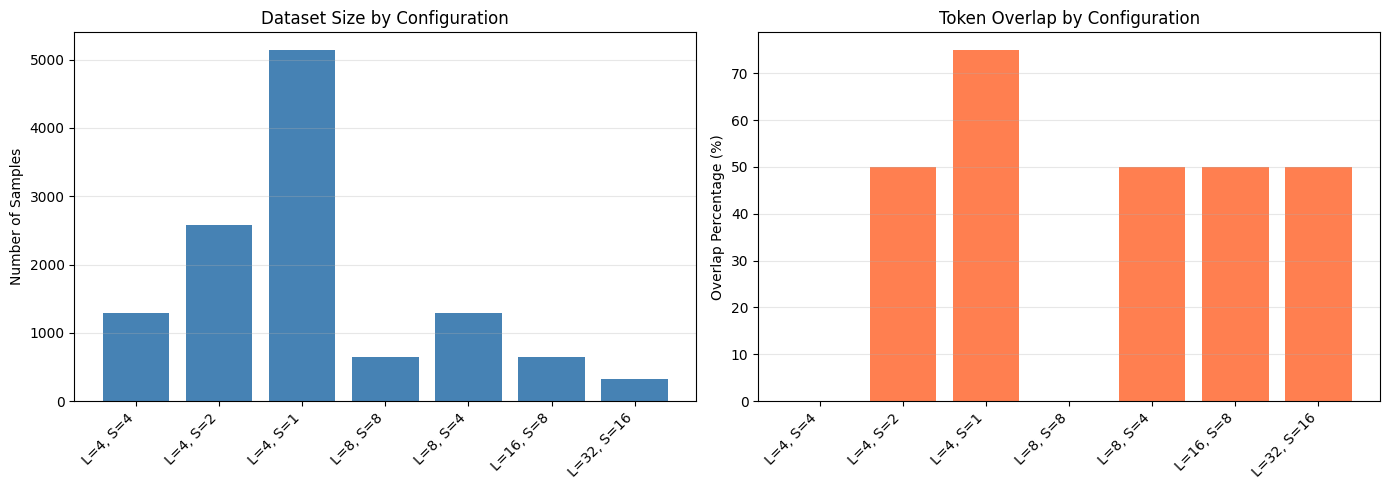

In [19]:
# Visualize results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Number of samples vs configuration
labels = [f"L={r[0]}, S={r[1]}" for r in results]
samples = [r[2] for r in results]
ax1.bar(range(len(results)), samples, color='steelblue')
ax1.set_xticks(range(len(results)))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Dataset Size by Configuration')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Overlap percentage
overlaps = [r[3] for r in results]
ax2.bar(range(len(results)), overlaps, color='coral')
ax2.set_xticks(range(len(results)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Overlap Percentage (%)')
ax2.set_title('Token Overlap by Configuration')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()